In [23]:
import numpy as np
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

api_keys = os.getenv('GROQ_API_KEYS').split(',') # Do not share this key with anyone
current_index =0

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}


In [ ]:
X_train = np.load('../Our_Saved/X_train.npy')
X_test = np.load('../Our_Saved/X_test.npy')
y_train = np.load('../Our_Saved/y_train.npy')
y_test = np.load('../Our_Saved/y_test.npy')

print(X_train.shape)
print(X_test.shape)
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train=np.hstack((X_train[:,:,0],X_train[:,:,1],X_train[:,:,2]))
X_test=np.hstack((X_test[:,:,0],X_test[:,:,1],X_test[:,:,2]))

print(f"x_train: {X_train.shape}")
print(f"x_test: {X_test.shape}")


X_train = X_train[:,:600]
X_test = X_test[:,:600]

print(f"x_train: {X_train.shape}")
print(f"x_test: {X_test.shape}")

In [ ]:
# List of API keys
api_key_index = -1  # Initialize index for API key rotation

# Set up your Groq model
model_name = "llama3.1-70b"

# Function to get the next API key in the list
def get_next_api_key():
    global api_key_index
    api_key_index = (api_key_index + 1) % len(api_keys)
    return api_keys[api_key_index]

def make_api_call(prompt, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            api_key = get_next_api_key()
            llm = ChatGroq(model=groq_models[model_name], api_key=api_key, temperature=0)
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            retries += 1
            print(f"Rate limit error with API key {api_keys.index(api_key)}. Error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying
    raise RuntimeError("Maximum retries reached. Failed to get a response from the API.")


(18, 500, 3)
(6, 500, 3)
y_train: (18,)
y_test: (6,)
x_train: (18, 1500)
x_test: (6, 1500)
x_train: (18, 600)
x_test: (6, 600)
content='6' response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 56209, 'total_tokens': 56211, 'completion_time': 0.008221374, 'prompt_time': 13.328977727, 'queue_time': 0.012022175000000246, 'total_time': 13.337199101}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'stop', 'logprobs': None} id='run-a4cb9446-5314-4cae-a21a-b701bc5c3c79-0' usage_metadata={'input_tokens': 56209, 'output_tokens': 2, 'total_tokens': 56211}
Test Case 1 (LAYING):
Predicted label: 6
True label: 6
--------------------------------------------------
content='4' response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 56200, 'total_tokens': 56202, 'completion_time': 0.008063879, 'prompt_time': 13.257100238, 'queue_time': 0.01107172700000092, 'total_time': 13.265164117}, 'model_name': 'llama-3.1-70

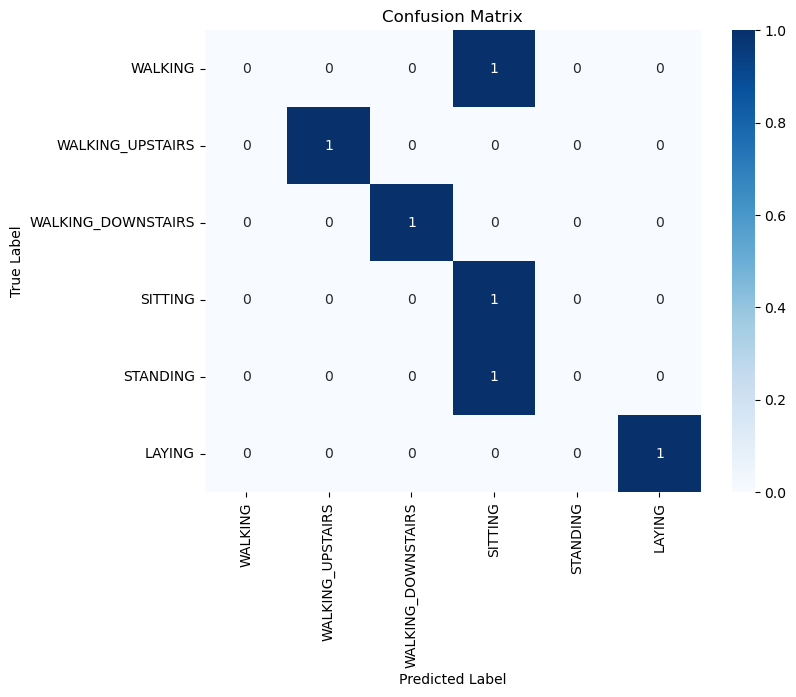

In [35]:
# Select even samples for few-shot learning examples
samples_per_activity = 3
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a 1x600 vector containing numerical values that represent transformed features.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt


# Select 3 samples from each activity for testing
samples_per_activity = 1
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    print(answer)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")


# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
if not os.path.exists('./Saved_Images/'):
    os.makedirs('./Saved_Images/')
plt.savefig('./Saved_Images/image4.png')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

The Few-Shot Learning model correctly classified only 2 out of 6 test cases, resulting in an accuracy of 33%.

While the model successfully identified the "LAYING" and "SITTING" activities, it struggled with distinguishing between more dynamic activities like "WALKING," "WALKING_DOWNSTAIRS," "WALKING_UPSTAIRS," and "STANDING," leading to multiple misclassifications.

Key factors that could contribute to this performance:

Limited Number of Examples: The few-shot approach relies on a small set of examples, which may not provide enough context for the model to accurately distinguish between similar activities.

Limited number of test dataset: Testing on one sample for each activity is not enough , as that one sample may be an outlier/